<a href="https://colab.research.google.com/github/WenhuiWang2023/springboard/blob/master/Ultimate_Technologies_Inc_Take_Home_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# imports
import pandas as pd
import numpy as np
import json
import pickle
# data viz imports
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import seaborn as sns
# time-series imports
from datetime import datetime
# imports for xgboost
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, cv, plot_importance

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import warnings
warnings.filterwarnings("ignore")

#**Part 1 ‐ Exploratory data analysis**<br>
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

## load data and exploration

In [4]:
# load data
login_data = pd.read_json('/content/logins.json')
# add a count column
login_data['login_count'] = 1
# convert the date to a datetime object, and set timestamp as the index
login_data = login_data.set_index(pd.to_datetime(login_data['login_time'], unit='s'))[['login_count']]
# check the data format
login_data.head()

,login_count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [5]:
# resample the index, so that time is represented in 15min chunks
logins_delta15min = login_data.resample('15Min').sum()

##**Data Visualization**

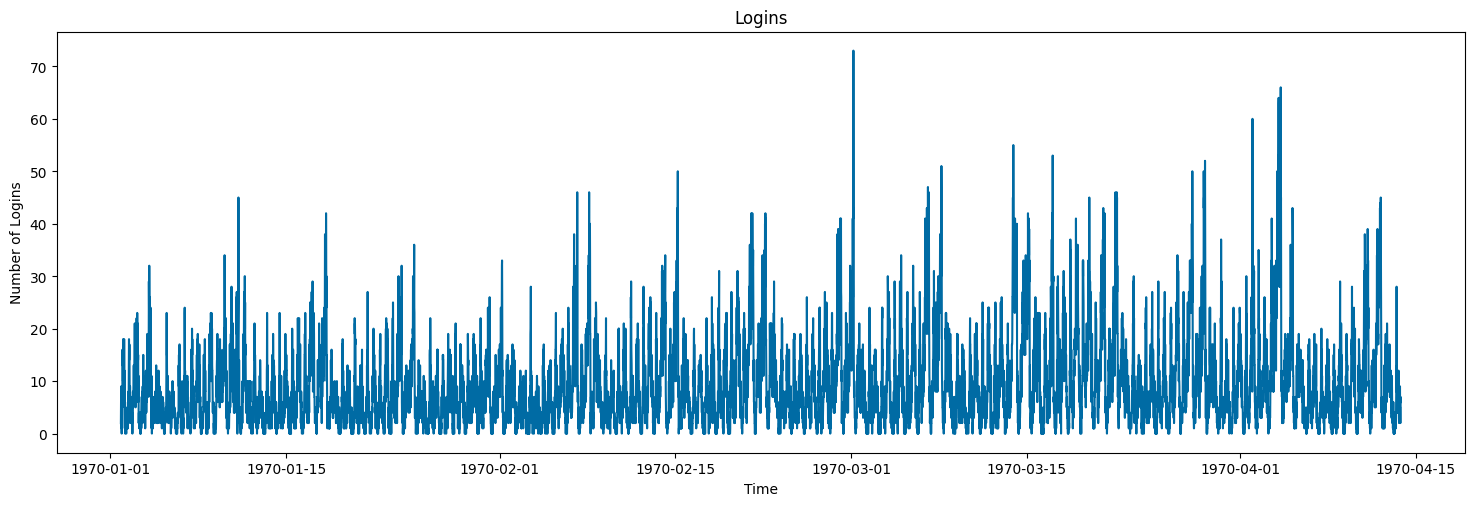

In [6]:
# scatterplot of the binned data
fig, ax = plt.subplots(figsize = (15,5))
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.tight_layout()
plt.title('Logins')
# puts the data in the figure
plt.plot(logins_delta15min.index, logins_delta15min.login_count)

It does look like there is an circle pattern in the data, but it is hard to see at this scale. We need to further process the data

**Better understand time-series data** <br>


*   Check the entire time-series with larger chunksize <br>
*   Check specific days separately <br>
*   Find the busiest time of day<br>






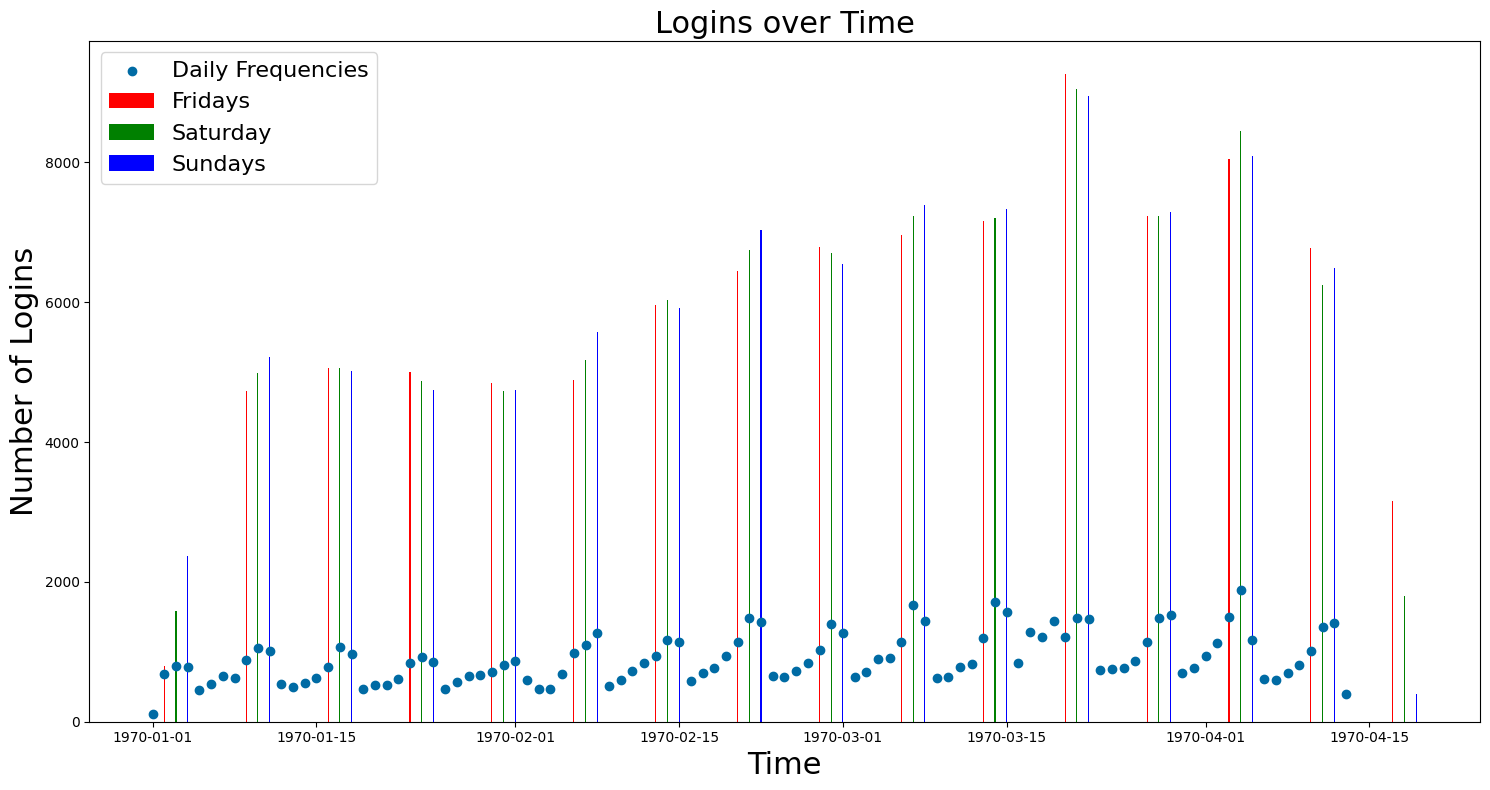

In [7]:
# bin the data by the day
logins_daily = login_data.resample('D').sum()
fridays = login_data.resample('W-FRI').sum()
saturdays = login_data.resample('W-SAT').sum()
sundays = login_data.resample('W-SUN').sum()


# line, scatterplot, and histograms of the binned data
fig, ax = plt.subplots(figsize = (15,8))
plt.xlabel('Time', fontsize = 22)
plt.ylabel('Number of Logins', fontsize = 22)
plt.title('Logins over Time', fontsize = 22)

plt.bar(fridays.index, fridays.login_count, align= 'center', width = 0.1, label = "Fridays", color = 'r')
plt.bar(saturdays.index, saturdays.login_count, label = 'Saturday', align = 'center', width = 0.1, color = 'g')
plt.bar(sundays.index, sundays.login_count, label = "Sundays", align= 'center', width = 0.1, color = 'b')
plt.scatter(logins_daily.index, logins_daily.login_count, label = 'Daily Frequencies')

plt.legend(loc='upper left', fontsize = 16)
plt.tight_layout()

The above graph makes it clear that Friday, Saturday and Sunday has the most logins, ammong which Saturday is the top busy day.


##Find hourly trends by day of week##

In [8]:
# resample index hourly
daily_logins = login_data.resample('H').sum()
# make a column that identify the day of week; Monday=0, Sunday=6
day_of_week = list(daily_logins.index.dayofweek)
daily_logins['day_of_week'] = day_of_week
# add column with just the hour (omiting the date)
daily_logins['hour'] = [time.hour for time in daily_logins.index]

In [9]:
# create dataframe of the average number of logins for each hour of each day
avg_hourly_logins = pd.pivot_table(daily_logins, values = 'login_count', index = 'hour', columns = 'day_of_week', aggfunc=np.mean).rename(columns= {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})
# stack
avg_hourly_logins = avg_hourly_logins.stack(level=['day_of_week'])
# name the stack
avg_hourly_logins.name = 'avg_num_logins'
avg_hourly_logins_df = avg_hourly_logins.reset_index()

In [10]:
avg_hourly_logins_df.head()

,hour,day_of_week,avg_num_logins
0,0,Monday,35.400000
1,0,Tuesday,43.357143
2,0,Wednesday,49.071429
3,0,Thursday,58.285714
4,0,Friday,65.000000


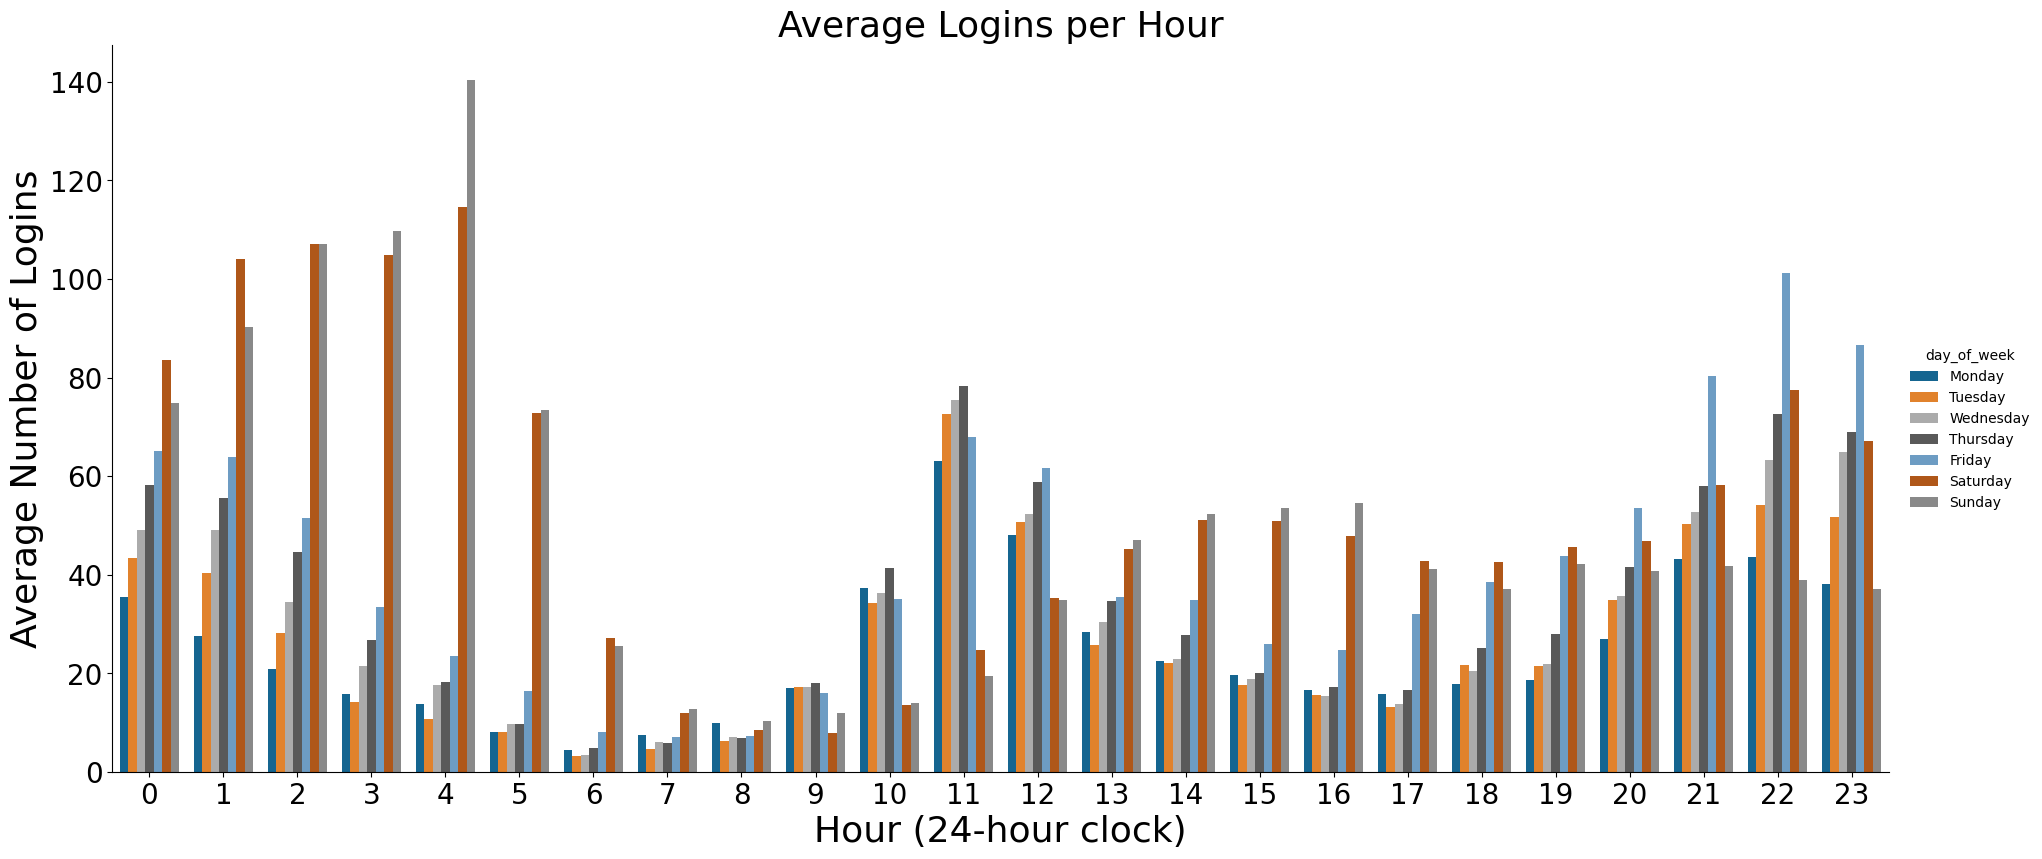

In [11]:
# plot average hourly use
sns.catplot(x='hour', y='avg_num_logins', data=avg_hourly_logins_df, kind = 'bar',
            hue='day_of_week',height=8, aspect=11.7/5, legend='brief')
ax = plt.gca()
ax.set_title('Average Logins per Hour', fontsize = 26)
ax.set_xlabel('Hour (24-hour clock)', fontsize = 26)
ax.set_ylabel('Average Number of Logins', fontsize = 26)
ax.tick_params(labelsize=20,labelcolor="black")


The bar graph shows the busiest usage occurs during the early morning hours (1 AM - 5 AM) on Saturday and Sunday. During the weekdays there are smaller spikes in usage during lunch hours (11 am to noon), and in the evening (9 PM - 11 PM).

#**Part 2 ‑ Experiment and metrics design**
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
how you will implement the experiment
what statistical test(s) you will conduct to verify the significance of the observation
how you would interpret the results and provide recommendations to the city operations team along with any caveats.

**To clarify the problem I am making the following assumptions:*

There is an electronic record of the number of cars that use the bridge. <br>
There is historical data on bridge use. <br><br>

The key metric I would use is change in weekday activity. Specifically, during the daytime hours on weekdays, is there **significant** increase of cars entering the bridge from Gotham?  AND during the night is there an **significant** increase of cars entering the bridge from Metropolis. <br>

In order to answer the above questions I would use two hypothesis tests.

H0: There is no difference between the mean number of cars entering the bridge from Gotham during weekdays between 6 am and 6 pm, two weeks before reimbursements were offered and the mean number of cars two weeks after reimbursements were offered.

H2: There is an INCREASE in the mean number of cars entering the bridge from Gotham during weekdays between 6 am and 6 pm, two weeks before reimbursements were offered and the mean number of cars two weeks after reimbursements were offered.

H0: There is no difference between the mean number of cars entering the bridge from Metropolis during weekdays between 7 pm and 4 am, two weeks before reimbursements were offered and the mean number of cars two weeks after reimbursements were offered.

H2: There is an INCREASE in the mean number of cars entering the bridge from Metropolis during weekdays between 7 pm and 4 am, two weeks before reimbursements were offered and the mean number of cars two weeks after reimbursements were offered.

I would use a one-tailed Z-test to determine the p-value of each hypothesis.

If the p-value is less than 0.05 for BOTH tests I would reject the null hypotheses and recommend the reimbursement program continue.

If the p-value is greater than 0.05 for BOTH tests I would not reject the null hypotheses and recommend that a reimburse toll fee has none effect on driver activity between two cities.

If the p-value is mixed, so only one hypothesis has a p-value less than 0.05,  I would recommend the one with p-value less than 0.05 should keep the reimbursement program.

#**Part 3 ‑ Predictive modeling**
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. <br><br>

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. <br><br>

The data is in the attached file ultimate_data_challenge.json. <br><br>

Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?<br><br>
Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).<br><br>

##Load data and exploration

In [12]:
# load data
with open('/content/ultimate_data_challenge.json') as f:
    data = json.load(f)

# put data info pandas dataframe
user_data = pd.DataFrame(data)

# convert dates to datetime objects
user_data['signup_date'] = pd.to_datetime(user_data['signup_date'])
user_data['last_trip_date'] = pd.to_datetime(user_data['last_trip_date'])

# find the date the data was pulled
pull_date = user_data.last_trip_date.max()

# determine 30 days previous to the pull day
cut_off_day = pull_date - pd.Timedelta('30 days')

# add active status to dataframe 0= inactive, 1 = active
user_data['active_status'] = (user_data.last_trip_date > cut_off_day).astype('int')

# add dummies to categorical data
user_data = pd.get_dummies(user_data, columns = ['city', 'phone'])

In [13]:
# separate the active and inactive users
active_user = user_data[user_data.active_status == 1]
inactive_user = user_data[user_data.active_status == 0]

In [14]:
# fraction of the observed users that were retained
fraction = round((len(active_user.active_status)/len(user_data.active_status)) * 100, 2)
print('{} percent of users were retained.'.format(fraction))

36.62 percent of users were retained.


In [15]:
# calculate the mean and standard deviation for each feature
feature_columns = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'city_Astapor',
 "city_King's Landing", 'city_Winterfell', 'phone_Android','phone_iPhone']
stats_dict = {}
for col in feature_columns:
    stats_dict[col] = [active_user[col].mean(), active_user[col].std(),
                       inactive_user[col].mean(),inactive_user[col].std()]

In [16]:
# create a dataframe of the statistics
stats_df = pd.DataFrame.from_dict(stats_dict, orient='index').rename(columns = {0:'active_mean', 1:'active_std', 2:'inactive_mean', 3:'inactive_std'})

Text(0.5, 1.0, 'Average of Features for Active and Inactive Users')

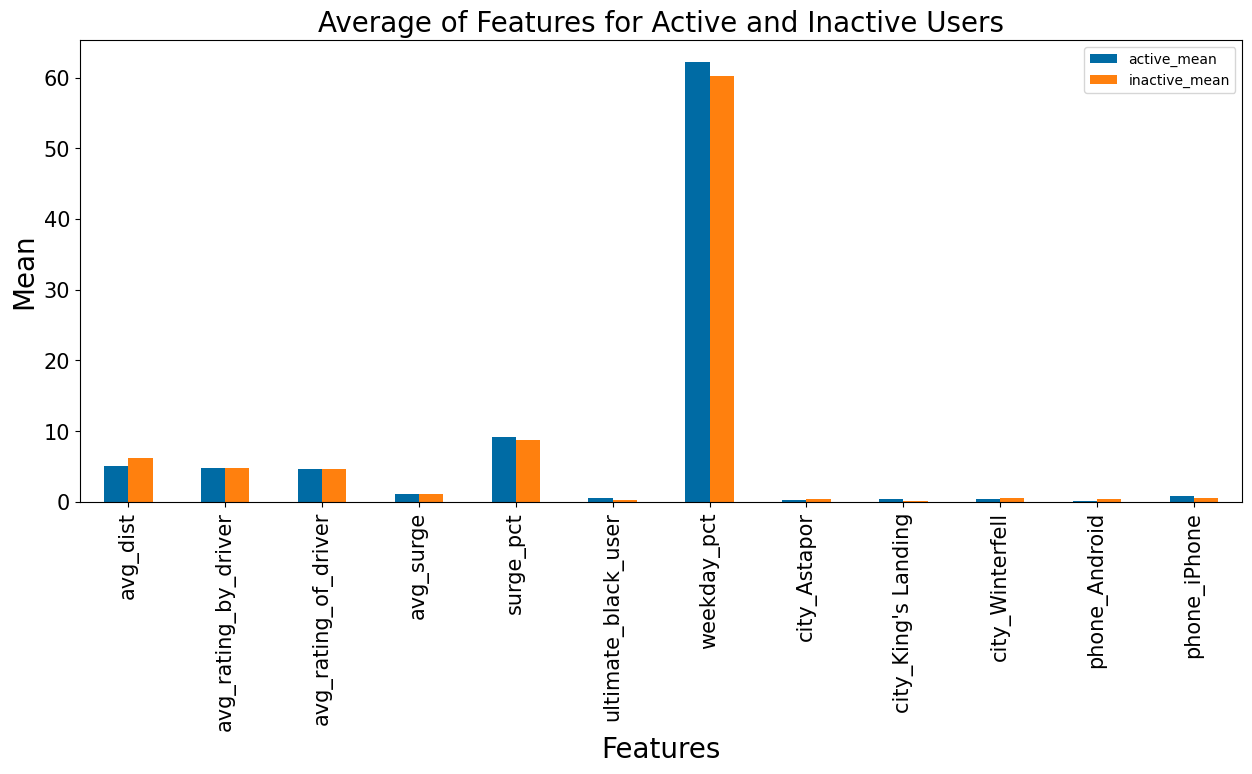

In [17]:
# visualize the statistics
stats_df[['active_mean', 'inactive_mean']].plot(kind = 'bar', yerr=stats_df[['active_std','inactive_std']], figsize = (15,6), fontsize = 15)
plt.xlabel('Features',fontsize = 20)
plt.ylabel('Mean', fontsize = 20)
plt.title('Average of Features for Active and Inactive Users', fontsize = 20)

The bar graph of the statistcs shows there is not a significant difference between the average of the features for active and inactive users. It also shows the weekday_pct feature has a much larger scale than the others, so the data may need to be scaled.

This is a binary classification problem with both numerical and categorical data with 50,000 data points. XGBoost is appropriate for the data, fast, and memory efficient. Other models that would be appropriate for this data would be random forests and logistic regression.

In [18]:
# define features and target
X = user_data[feature_columns]
y = user_data.active_status
# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=123)

In [27]:
# dictionary of parameters to optimize, and the range of optimization values
parameters = {
    'max_depth': [3, 4, 5],
    'scale_pos_weight':[0.95, 0.9],
    'subsample':[0.5,0.7,1],
    'learning_rate': [1e-5, 0.25, 0.2, 0.1],
    'min_child_weight': [1, 5, 10],
    'gamma':[0.5, 1, 2, 5]
    }

In [28]:
# instantiate classifier
xg_clf = XGBClassifier(objective = 'binary:logistic', random_state = 42, silent = 1, n_estimators=10, max_depth= 8)

# RandomSearch
grid_search = GridSearchCV(param_grid= parameters, estimator = xg_clf, cv=3, scoring='accuracy')
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=10,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'gamma': [0.5, 1, 2, 5],
                         'learning_rate': [1e-05, 0.25, 0.2, 0.1],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 5, 10],
                         'scale_pos_weight': [0.95, 0.9],
                         'subsample': [0.5, 0.7, 1]},
             scoring='accuracy')

In [29]:
# Print best parameters and results
print(grid_search.best_params_)
print(grid_search.best_score_)

{'gamma': 5, 'learning_rate': 0.25, 'max_depth': 5, 'min_child_weight': 1, 'scale_pos_weight': 0.95, 'subsample': 1}
0.783028618422614


In [30]:
# optimized parameters
optimized_parameters = {'objective':'binary:logistic',
                        'n_estimators': 10,
                        'random_state': 42,
                        'silent': 0,
                        'subsample': 1,
                        'scale_pos_weight': 0.95,
                        'min_child_weight': 1,
                        'max_depth': 8,
                        'max_delta_step': 0,
                        'learning_rate': 0.2,
                        'gamma': 3
                       }

In [31]:
# instantiate classifier
xg_clf_opt = XGBClassifier(**optimized_parameters)
xg_clf_opt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=8, max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=10,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [32]:
# predict the labels
y_opt_pred = xg_clf_opt.predict(X_train)
# score model
score = accuracy_score(y_train, y_opt_pred)
# print accuracy
print("The resulting accuracy of the optimized classifier is {}.".format(round(score,4)))

The resulting accuracy of the optimized classifier is 0.8007.


In [33]:
# predict the labels
y_opt_test = xg_clf_opt.predict(X_test)
# score model
test_score = accuracy_score(y_test, y_opt_test)
# print accuracy
print("The resulting accuracy of the optimized classifier for the test set is {}.".format(round(test_score,4)))

The resulting accuracy of the optimized classifier for the test set is 0.7874.


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

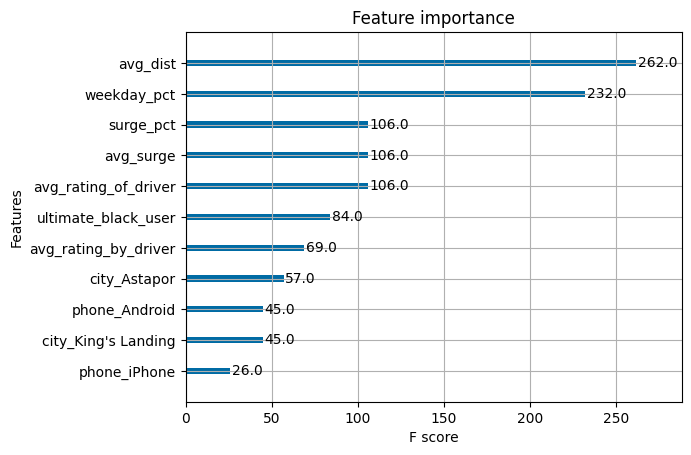

In [34]:
plot_importance(xg_clf_opt)


#**Conclusions**
The optimized parameters result in a classification accuracy of 78.74% for the test data. The factors that most heavily influence rider retention are the average distance in miles per trip taken in the first 30 days after signup and the percent of the user's trips occuring during a weekday.